In [1]:
!pip install pymorphy3
!pip install catboost
!pip install transformers

In [92]:
import string
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
from pymorphy3 import MorphAnalyzer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from transformers import BertForSequenceClassification, BertTokenizer, AdamW
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve
from sklearn.neighbors import NearestNeighbors
import torch.nn.functional as F


import torch
from torch import nn
from tqdm import tqdm
from catboost import CatBoostClassifier
import warnings

warnings.filterwarnings('ignore')

## Preprocess texts

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
# path = '/content/drive/My Drive/Term/texts_labeled.tsv'
path = '/Users/nikitasenyatkin/Documents/Мага/2 курс/Thesis/wb-category-analysis/texts_labeled.tsv'

In [61]:
df = pd.read_csv(path, sep='\t')

In [62]:
res = df.groupby('INPUT:comment')['OUTPUT:is_infringements'].apply(lambda row: row.value_counts().idxmax()).reset_index()
res

,INPUT:comment,OUTPUT:is_infringements
0,\r\nВРЕМЯ ПИТЬ ЧАЙ!\r\nBrusnikaTea «ЯГОДНЫЙ» -...,yes
1,\r\nВкусный чай зеленый листовой ягодами земля...,no
2,\r\nИван чай Глазова Гора – традиционный русск...,no
3,\r\nИщете идеальный подарок на Новый год? Пода...,no
4,\r\nНастоящий Молочный улун высший сорт из Кит...,yes
...,...,...
2003,Яркий фруктово-ягодный купаж на основе облепих...,yes
2004,Ярко выраженное восточное благоухание зелёного...,no
2005,пакетиках 14 матча день зеленый черный рождени...,no
2006,улун дыня - разновидность крупнолистового чая...,no


In [63]:
df[df['INPUT:comment'] == '\r\nВкусный чай зеленый листовой ягодами земляники. Земляничный улун подарочный. Улун китайский и ягоды сушеные (земляника сублимированная) возвратят Вас в лето и превратят чаепитие в праздник. Сублимированные ягоды и крупнолистовой зелёный чай укрепят здоровье. Содержит витамины D, C, E, K, марганец, фосфор, железо и йод. Чай заварной с натуральными добавками выводит шлаки и токсины из организма. Напиток можно использовать для детокса и похудения. Чай с ягодами имеет обволакивающий вкус и нежный аромат. Фруктовый чай натуральный антиоксидант, полезен для похудения, укрепляет костные ткани. Чайное ассорти изготовлено без искусственных красителей и не содержит ГМО. Чай подарочный ягодный микс в подарок женщине, мужчине. Чай с фруктами можно подать во время застолья на новогодний праздник. Оригинальный и нежный вкус наверняка понравится гостям. Состав: чай китайский улун, ягоды земляники, лист брусники, натуральный земляничный ароматизатор. После него Вы забудете про чай в пакетиках. сушеные ягоды, лепестки и травы - чайный напиток с натуральными витаминами и полезными минералами. Практичный, универсальный подарок с пользой для здоровья удивит и вызовет положительные эмоции, а также даст повод собраться с друзьями и родными за чашечкой чая. После него Вы забудете про чай в пакетиках. Тонизирующее, так и успокаивающее воздействие. ']

,INPUT:comment,OUTPUT:insult,OUTPUT:nonsense,OUTPUT:profanity,OUTPUT:advertising,OUTPUT:law_violation,OUTPUT:is_infringements,GOLDEN:insult,GOLDEN:nonsense,GOLDEN:profanity,...,GOLDEN:law_violation,GOLDEN:is_infringements,HINT:text,HINT:default_language,ASSIGNMENT:link,ASSIGNMENT:task_id,ASSIGNMENT:assignment_id,ASSIGNMENT:worker_id,ASSIGNMENT:status,ASSIGNMENT:started
4853,\r\nВкусный чай зеленый листовой ягодами земля...,NaN,NaN,NaN,NaN,NaN,no,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,https://platform.toloka.ai/task/42935533/00028...,00028f24ed--661febdf1c7df82555cadd30,00028f24ed--661ff1997d5f9b2330ba2f9c,5f271f4fb1d5d003e454617253cc57d8,APPROVED,2024-04-17T15:58:17.613
4901,\r\nВкусный чай зеленый листовой ягодами земля...,NaN,NaN,NaN,True,NaN,yes,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,https://platform.toloka.ai/task/42935533/00028...,00028f24ed--661febdf1c7df82555cadd30,00028f24ed--661ff19bdaf59030df3c69c2,bfdb99f582393c82a7545545bc7044fb,APPROVED,2024-04-17T15:58:19.082
4953,\r\nВкусный чай зеленый листовой ягодами земля...,NaN,NaN,NaN,NaN,NaN,no,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,https://platform.toloka.ai/task/42935533/00028...,00028f24ed--661febdf1c7df82555cadd30,00028f24ed--661ff19cdaf59030df3c69f7,2a38e4d4e4a4736d579c9e52f33b9075,APPROVED,2024-04-17T15:58:20.522


In [64]:
names = {
    'INPUT:comment' : 'comment',
    'OUTPUT:is_infringements' : 'target'
}

In [65]:
res.rename(names, axis=1, inplace=True)

In [10]:
# df['описание'] = df['описание'].fillna('Описания нет')
# df['бренд'] = df['бренд'].fillna('Бренда нет')

# df.info()

In [66]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nikitasenyatkin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [67]:
patterns = '[^0-9а-яА-ЯёЁ\s]+'
stopwords_ru = stopwords.words("russian")
morph = MorphAnalyzer()

def lemmatize(doc):
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        if token and token not in stopwords_ru:
            token = token.strip()
            token = morph.normal_forms(token)[0]

            tokens.append(token)
    return tokens

In [68]:
def preprocess_text(row):

    text = str(row).lower()

    # deleting punctuation
    punc = str.maketrans('', '', string.punctuation)
    text_no_punct = text.translate(punc)

    # lemmatizing
    lematized_text = lemmatize(text_no_punct)

    return lematized_text

In [69]:
def target_labeler(s):
    if s == 'yes':
        return 1
    if s == 'avg':
        return 1
    else:
        return 0

In [70]:
preprocessed_df = res.copy()
preprocessed_df['comment'] = res['comment'].apply(preprocess_text)
preprocessed_df['target'] = preprocessed_df['target'].apply(lambda row: target_labeler(row))

Опробовать сетки отсюда, если нет, то гг, придется что- то думать.
В противном случае генерация описаний или придумывание описательных фичей текста, которые могут помочь, вместо стандартных векторов

## Training embeddings


In [71]:
# creating tagged data
tagged_data = [TaggedDocument(words=d, tags=[str(i)]) for i, d in enumerate(preprocessed_df['comment'])]

# creating model
model = Doc2Vec(vector_size=25, window=2, min_count=1, workers=4, seed=42)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=5)

# receiving vecs
vectors = pd.DataFrame(model.infer_vector(doc.words) for doc in tagged_data)
# vectors = pd.DataFrame(model.dv.get_vector(str(i)) for i in range(len(tagged_data)))



In [72]:
def target_labeler(s):
    if s == 'yes':
        return 1
    if s == 'avg':
        return 1
    else:
        return 0

def counter(class_name):
    return preprocessed_df['target'].count()/preprocessed_df['target'][preprocessed_df['target']==class_name].count()

In [73]:
cb_df = pd.concat([vectors, preprocessed_df['target']], axis=1)
# cb_df['target'] = cb_df['target'].apply(lambda row: target_labeler(row))
# weights = [counter(0), counter(1), counter(2)]
cb_df


,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,target
0,0.220616,-0.584180,0.124026,-0.678434,-0.596027,-0.351055,0.198904,0.148530,-0.036486,-0.343035,...,0.378401,-0.093616,-0.165475,0.021340,0.074733,0.067088,0.943430,0.399883,0.436314,1
1,-0.128827,-0.265107,-0.117160,-0.090392,-0.159758,0.032678,-0.120282,0.066013,0.113221,-0.211117,...,0.281724,-0.111365,-0.254634,0.176622,0.221308,0.227323,0.321986,-0.027528,0.218121,0
2,-0.046367,-0.236453,0.107440,-0.250737,-0.329269,-0.115869,-0.000768,0.403920,0.072042,-0.002583,...,0.469560,-0.138503,-0.374971,-0.179433,-0.021338,0.390777,0.486149,0.366084,0.147256,0
3,-0.257964,-0.313339,-0.624738,-0.456974,-0.460429,-0.081196,-0.246090,0.106785,0.059004,-0.546147,...,0.360625,-0.486059,-0.406992,0.390301,0.248420,-0.103654,0.711125,0.094677,0.738721,0
4,0.064954,-0.410846,0.429969,-0.065224,0.154312,-0.283735,-0.110351,0.021634,-0.180701,-0.351758,...,0.178662,-0.158495,-0.281292,0.095516,-0.242509,0.141835,0.559364,0.448124,-0.043176,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2003,-0.014613,-0.363927,0.271316,-0.370102,-0.409500,-0.242177,-0.092273,0.215162,-0.204326,-0.190421,...,0.123317,0.112234,-0.161625,-0.092155,0.134661,0.354047,0.520094,0.346471,0.117331,1
2004,0.046938,-0.297665,0.232149,-0.197294,-0.191693,-0.173330,0.008265,0.032875,-0.046922,-0.092485,...,0.138677,-0.035957,-0.073509,-0.081550,0.077154,0.179880,0.384958,0.243841,0.060791,0
2005,-0.665997,0.117459,-0.734903,0.022810,0.325615,-0.260974,-0.463145,0.037628,0.042585,-0.019466,...,0.063010,-0.297724,-0.361819,-0.093339,0.045940,-0.230155,-0.243589,0.121035,0.589010,0
2006,-0.014592,-0.348805,0.291584,-0.126389,-0.003936,-0.462899,-0.046087,0.010926,-0.112173,-0.075841,...,0.243690,-0.022741,-0.411017,-0.100271,-0.295122,0.075646,0.530281,0.499044,0.062278,0


In [74]:
cb_df.target.value_counts()

target
0    1307
1     701
Name: count, dtype: int64

In [75]:
X = cb_df.drop('target', axis=1)

positive_indices = [i for i, label in enumerate(cb_df['target']) if label == 1]
negative_indices = [i for i, label in enumerate(cb_df['target']) if label == 0]

positive_vectors = X.loc[positive_indices]
negative_vectors = X.loc[negative_indices]

KNN for filtering data

In [76]:
def knn_pos_filtering(positive_vectors, negative_vectors, thresh):

  knn_model_pos = NearestNeighbors(n_neighbors=3, algorithm='ball_tree')
  knn_model_pos.fit(positive_vectors)

  distances, indices = knn_model_pos.kneighbors(negative_vectors)

  result = set()
  for i, (s, dist, idx) in enumerate(zip(negative_indices, distances, indices)):
      if dist.mean() < thresh:
        result.add(s)
  return list(result)


In [77]:
pos_filtering_bad_idx = knn_pos_filtering(positive_vectors, negative_vectors, 0.52)
print(len(pos_filtering_bad_idx))
print(preprocessed_df.loc[pos_filtering_bad_idx]['target'].value_counts())

647
target
0    647
Name: count, dtype: int64


In [78]:
def knn_neg_filtering(positive_vectors, negative_vectors, thresh):

  knn_model_pos = NearestNeighbors(n_neighbors=3, algorithm='ball_tree')
  knn_model_pos.fit(negative_vectors)

  distances, indices = knn_model_pos.kneighbors(positive_vectors)

  result = set()
  for distance in range(len(distances)):
    for i in range(3):
      if distances[distance][i] < thresh:
        result.add(negative_indices[indices[distance][i]])
  return list(result)


In [79]:
neg_filtering_bad_idx = knn_neg_filtering(positive_vectors, negative_vectors, 1.3)
print(len(neg_filtering_bad_idx))
print(preprocessed_df.loc[neg_filtering_bad_idx]['target'].value_counts())

865
target
0    865
Name: count, dtype: int64


In [80]:
# res.drop(neg_filtering_bad_idx)['target'].value_counts()
cb_df.drop(pos_filtering_bad_idx)['target'].value_counts()


target
1    701
0    660
Name: count, dtype: int64

## Logistic regression on doc2vec test

In [81]:
df = cb_df.drop(pos_filtering_bad_idx)
X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [82]:
model = LogisticRegression()

model.fit(X_train, y_train)
pred = model.predict(X_test)

acc = accuracy_score(y_test, pred)
print(acc)

0.652014652014652


## Catboost + Doc2Vec

In [83]:
cb = CatBoostClassifier(early_stopping_rounds=100, learning_rate=0.01)
cb.fit(X_train, y_train, verbose=0)
pred = cb.predict(X_test)

acc = accuracy_score(y_test, pred)
print(acc)

0.663003663003663


0.7355088020609705


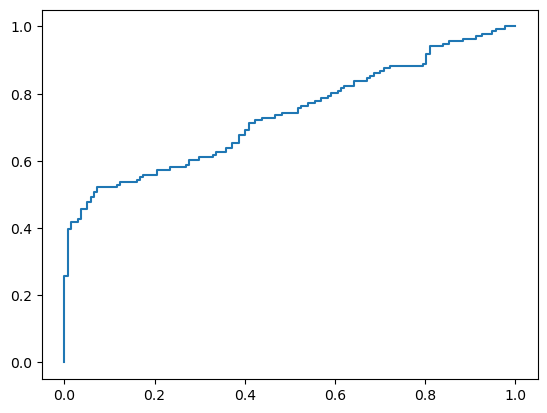

In [84]:
pred = cb.predict_proba(X_test)

print(roc_auc_score(y_test, pred[:,1]))

fpr, tpr, thres = roc_curve(y_test, pred[:,1])

plt.plot(fpr, tpr)

Logistic regression + doc2vec filtration + TFIDF

In [85]:
tf_data = preprocessed_df.drop(pos_filtering_bad_idx)
tf_data['comment'] = tf_data['comment'].apply(lambda row: ' '.join(row))
X = tf_data.drop('target', axis=1)
y = tf_data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [86]:
tfidf_1 = TfidfVectorizer(ngram_range=(1, 1))


In [87]:
tfidf_train = tfidf_1.fit_transform(X_train['comment'])
tfidf_test = tfidf_1.transform(X_test['comment'])

print(tfidf_train.shape)
print(tfidf_test.shape)

(1088, 9124)
(273, 9124)


In [88]:
model = LogisticRegression()

model.fit(tfidf_train, y_train)
pred = model.predict(tfidf_test)

acc = accuracy_score(y_test, pred)
print(acc)

0.6593406593406593


## CATBOOST + TFIDF

In [34]:
cb = CatBoostClassifier(early_stopping_rounds=100, learning_rate=0.01)
cb.fit(tfidf_train, y_train, verbose=0)
pred = cb.predict(tfidf_test)

acc = accuracy_score(y_test, pred)
print(acc)

0.6897810218978102


0.7583266719957368


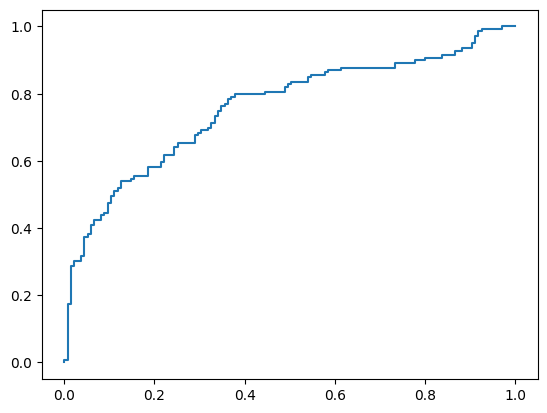

In [35]:
pred = cb.predict_proba(tfidf_test)

print(roc_auc_score(y_test, pred[:,1]))

fpr, tpr, thres = roc_curve(y_test, pred[:,1])

plt.plot(fpr, tpr)

TFIDF works worse, so let's try DOC2VEC + LSTM

## FC + DOC2VEC

In [89]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [90]:
l_df = cb_df.copy()
X = l_df.drop('target', axis=1)
y = l_df['target']

features = X.values
targets = y.values

X_train, X_test, y_train, y_test = train_test_split(features, targets, random_state=42, test_size=0.8)

X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [121]:
vocab_size = 2000
input_len = 25
hidden_size = 128
num_layers = 2
num_classes = 2
n_epochs = 5
learning_rate = 0.001

In [128]:
class FC(nn.Module):
    def __init__(self, input_size, num_classes):
        super(FC, self).__init__()
        self.fc1 = nn.Linear(input_size, 128, bias=True)
        self.fc2 = nn.Linear(128, num_classes, bias=True)

        self.dropout1 = nn.Dropout(0.4)


    def forward(self, X):
        out = F.relu(self.fc1(X))
        out = self.dropout1(out)
        out = F.relu(self.fc2(out))

        return out


In [129]:
model = FC(input_len, num_classes)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

In [130]:
criterion = nn.CrossEntropyLoss()

num_epochs = 500

for epoch in range(num_epochs):
    total_loss = 0
    total_correct = 0
    total_samples = 0

    model.train()  # Переключение в режим обучения
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted_classes = torch.max(outputs, 1)
        correct_predictions = (predicted_classes == targets).float()
        total_correct += correct_predictions.sum().item()
        total_samples += targets.size(0)

    average_loss = total_loss / len(train_loader)
    accuracy = total_correct / total_samples
    print(f"TRAIN: Epoch {epoch + 1}, Average Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}")


    total_loss = 0
    total_correct = 0
    total_samples = 0

    model.eval()
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            total_loss += loss.item()
            _, predicted_classes = torch.max(outputs, 1)
            correct_predictions = (predicted_classes == targets).float()
            total_correct += correct_predictions.sum().item()
            total_samples += targets.size(0)

    average_loss = total_loss / len(test_loader)
    accuracy = total_correct / total_samples
    print(f"TEST: Epoch {epoch + 1}, Average Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}")
    print('='*30)

TRAIN: Epoch 1, Average Loss: 0.6836, Accuracy: 0.6135
TEST: Epoch 1, Average Loss: 0.6621, Accuracy: 0.6584
TRAIN: Epoch 2, Average Loss: 0.6680, Accuracy: 0.6209
TEST: Epoch 2, Average Loss: 0.6498, Accuracy: 0.6584
TRAIN: Epoch 3, Average Loss: 0.6656, Accuracy: 0.6209
TEST: Epoch 3, Average Loss: 0.6479, Accuracy: 0.6584
TRAIN: Epoch 4, Average Loss: 0.6615, Accuracy: 0.6209
TEST: Epoch 4, Average Loss: 0.6500, Accuracy: 0.6584
TRAIN: Epoch 5, Average Loss: 0.6609, Accuracy: 0.6209
TEST: Epoch 5, Average Loss: 0.6483, Accuracy: 0.6584
TRAIN: Epoch 6, Average Loss: 0.6604, Accuracy: 0.6209
TEST: Epoch 6, Average Loss: 0.6453, Accuracy: 0.6584
TRAIN: Epoch 7, Average Loss: 0.6609, Accuracy: 0.6209
TEST: Epoch 7, Average Loss: 0.6437, Accuracy: 0.6584
TRAIN: Epoch 8, Average Loss: 0.6579, Accuracy: 0.6209
TEST: Epoch 8, Average Loss: 0.6477, Accuracy: 0.6584
TRAIN: Epoch 9, Average Loss: 0.6586, Accuracy: 0.6209
TEST: Epoch 9, Average Loss: 0.6460, Accuracy: 0.6584
TRAIN: Epoch 10, Av

## Test bert for embeddings

Правильно обработать bert 

In [ ]:
device = 'cuda'

In [26]:
res['target'] = res['target'].apply(lambda x: target_labeler(x))
res['target'].value_counts()

target
0    1308
1     701
Name: count, dtype: int64

In [ ]:
res.drop(neg_filtering_bad_idx)['target'].value_counts()
res.drop(pos_filtering_bad_idx)['target'].value_counts()


target
0    712
1    701
Name: count, dtype: int64

In [27]:
res

,comment,target
0,\r\nВРЕМЯ ПИТЬ ЧАЙ!\r\nBrusnikaTea «ЯГОДНЫЙ» -...,1
1,\r\nВкусный чай зеленый листовой ягодами земля...,0
2,\r\nИван чай Глазова Гора – традиционный русск...,0
3,\r\nИщете идеальный подарок на Новый год? Пода...,0
4,\r\nНастоящий Молочный улун высший сорт из Кит...,1
...,...,...
2004,Ярко выраженное восточное благоухание зелёного...,0
2005,пакетиках 14 матча день зеленый черный рождени...,0
2006,улун дыня - разновидность крупнолистового чая...,0
2007,"чай чёрный, рассыпной, масала, специи, саган д...",0


In [ ]:
def preprocess_for_bert(df, batch=32):

  comments = df['comment'].to_list()
  labels = df['target'].to_list()
  tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

  # Токенизация данных
  input_ids = []
  attention_masks = []

  for comment in comments:
      encoded_data = tokenizer.encode_plus(
          comment,
          add_special_tokens=True,
          max_length=64,
          pad_to_max_length=True,
          return_attention_mask=True,
          return_tensors='pt'
      )
      input_ids.append(encoded_data['input_ids'])
      attention_masks.append(encoded_data['attention_mask'])

  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)

  train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=42, test_size=0.2)
  train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, random_state=42, test_size=0.2)

  train_data = TensorDataset(train_inputs, train_masks, train_labels)
  train_sampler = RandomSampler(train_data)
  train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch)

  validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
  validation_sampler = SequentialSampler(validation_data)
  validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch)

  return train_data, train_sampler, train_dataloader, validation_data, validation_sampler, validation_dataloader


BERT on pos filtering

In [ ]:
train_data, train_sampler, train_dataloader, validation_data, validation_sampler, validation_dataloader = preprocess_for_bert(res.drop(pos_filtering_bad_idx), 32)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=2)
model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [ ]:
train_loss_set = []
train_accuracy_set = []
validation_accuracy_set = []
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=2)
model.dropout = nn.Dropout(0.2, inplace=False)
model.classifier = nn.Sequential(
    nn.Linear(768, 384),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(384,2),
)
model.to(device)

optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)

model.train()
for epoch in range(10):
    total_train_accuracy = 0
    total_train_loss = 0

    for step, batch in enumerate(tqdm(train_dataloader, desc="Epoch {}".format(epoch))):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        model.zero_grad()

        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        logits = outputs.logits
        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()


        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to(device).cpu().numpy()

        total_train_accuracy += flat_accuracy(logits, label_ids)

    avg_train_accuracy = total_train_accuracy / len(train_dataloader)
    avg_train_loss = total_train_loss / len(train_dataloader)
    train_accuracy_set.append(avg_train_accuracy)
    train_loss_set.append(avg_train_loss)

    print(" Average training accuracy: {0:.2f}".format(avg_train_accuracy))
    print(" Average training loss: {0:.2f}".format(avg_train_loss))


    model.eval()
    total_eval_accuracy = 0

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        logits = outputs.logits
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.cpu().numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    validation_accuracy_set.append(avg_val_accuracy)
    print(" Validation Accuracy: {0:.2f}".format(avg_val_accuracy))



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 0: 100%|██████████| 51/51 [00:17<00:00,  2.85it/s]


 Average training accuracy: 0.64
 Average training loss: 0.65
 Validation Accuracy: 0.64


Epoch 1: 100%|██████████| 51/51 [00:18<00:00,  2.81it/s]


 Average training accuracy: 0.66
 Average training loss: 0.64
 Validation Accuracy: 0.64


Epoch 2: 100%|██████████| 51/51 [00:18<00:00,  2.73it/s]


 Average training accuracy: 0.65
 Average training loss: 0.64
 Validation Accuracy: 0.64


Epoch 3: 100%|██████████| 51/51 [00:18<00:00,  2.78it/s]


 Average training accuracy: 0.66
 Average training loss: 0.63
 Validation Accuracy: 0.64


Epoch 4: 100%|██████████| 51/51 [00:18<00:00,  2.82it/s]


 Average training accuracy: 0.74
 Average training loss: 0.56
 Validation Accuracy: 0.56


Epoch 5: 100%|██████████| 51/51 [00:18<00:00,  2.80it/s]


 Average training accuracy: 0.82
 Average training loss: 0.43
 Validation Accuracy: 0.59


Epoch 6: 100%|██████████| 51/51 [00:18<00:00,  2.77it/s]


 Average training accuracy: 0.89
 Average training loss: 0.31
 Validation Accuracy: 0.55


Epoch 7: 100%|██████████| 51/51 [00:18<00:00,  2.78it/s]


 Average training accuracy: 0.94
 Average training loss: 0.21
 Validation Accuracy: 0.56


Epoch 8: 100%|██████████| 51/51 [00:18<00:00,  2.78it/s]


 Average training accuracy: 0.95
 Average training loss: 0.18
 Validation Accuracy: 0.59


Epoch 9: 100%|██████████| 51/51 [00:18<00:00,  2.80it/s]


 Average training accuracy: 0.95
 Average training loss: 0.17
 Validation Accuracy: 0.62


In [ ]:
train_data, train_sampler, train_dataloader, validation_data, validation_sampler, validation_dataloader = preprocess_for_bert(res.drop(neg_filtering_bad_idx), 32)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
train_loss_set = []
train_accuracy_set = []
validation_accuracy_set = []
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=2)
# model.dropout = nn.Dropout(0.2, inplace=False)
model.classifier = nn.Sequential(
    nn.Linear(768, 384),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(384,2),
)
model.to(device)

optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)

model.train()
for epoch in range(10):
    total_train_accuracy = 0
    total_train_loss = 0

    for step, batch in enumerate(tqdm(train_dataloader, desc="Epoch {}".format(epoch))):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        model.zero_grad()

        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        logits = outputs.logits
        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()


        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to(device).cpu().numpy()

        total_train_accuracy += flat_accuracy(logits, label_ids)

    avg_train_accuracy = total_train_accuracy / len(train_dataloader)
    avg_train_loss = total_train_loss / len(train_dataloader)
    train_accuracy_set.append(avg_train_accuracy)
    train_loss_set.append(avg_train_loss)

    print(" Average training accuracy: {0:.2f}".format(avg_train_accuracy))
    print(" Average training loss: {0:.2f}".format(avg_train_loss))


    model.eval()
    total_eval_accuracy = 0

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        logits = outputs.logits
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.cpu().numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    validation_accuracy_set.append(avg_val_accuracy)
    print(" Validation Accuracy: {0:.2f}".format(avg_val_accuracy))



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 0: 100%|██████████| 51/51 [00:18<00:00,  2.78it/s]


 Average training accuracy: 0.65
 Average training loss: 0.65
 Validation Accuracy: 0.64


Epoch 1: 100%|██████████| 51/51 [00:18<00:00,  2.70it/s]


 Average training accuracy: 0.65
 Average training loss: 0.65
 Validation Accuracy: 0.64


Epoch 2: 100%|██████████| 51/51 [00:18<00:00,  2.77it/s]


 Average training accuracy: 0.66
 Average training loss: 0.63
 Validation Accuracy: 0.63


Epoch 3: 100%|██████████| 51/51 [00:18<00:00,  2.82it/s]


 Average training accuracy: 0.70
 Average training loss: 0.58
 Validation Accuracy: 0.64


Epoch 4: 100%|██████████| 51/51 [00:18<00:00,  2.81it/s]


 Average training accuracy: 0.83
 Average training loss: 0.42
 Validation Accuracy: 0.58


Epoch 5: 100%|██████████| 51/51 [00:18<00:00,  2.78it/s]


 Average training accuracy: 0.91
 Average training loss: 0.27
 Validation Accuracy: 0.57


Epoch 6: 100%|██████████| 51/51 [00:18<00:00,  2.78it/s]


 Average training accuracy: 0.93
 Average training loss: 0.21
 Validation Accuracy: 0.57


Epoch 7: 100%|██████████| 51/51 [00:18<00:00,  2.79it/s]


 Average training accuracy: 0.95
 Average training loss: 0.16
 Validation Accuracy: 0.61


Epoch 8: 100%|██████████| 51/51 [00:18<00:00,  2.80it/s]


 Average training accuracy: 0.95
 Average training loss: 0.13
 Validation Accuracy: 0.61


Epoch 9: 100%|██████████| 51/51 [00:18<00:00,  2.79it/s]


 Average training accuracy: 0.95
 Average training loss: 0.11
 Validation Accuracy: 0.59


## Начинаем с простых методов

In [62]:
res['target'] = res['target'].apply(lambda row: target_labeler(row))

In [ ]:
vocab_size = 15000
input_len = 300
hidden_size = 128
num_layers = 2
num_classes = 2
n_epochs = 5
learning_rate = 0.001

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_classes, num_layers):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True)
        self.output_layer = nn.Linear(hidden_size, num_classes)

    def forward(self, X):
        embedded_X = self.embedding(X)
        hidden_states = torch.zeros(self.num_layers, X.size(0), self.hidden_size).to(X.device)
        cell_states = torch.zeros(self.num_layers, X.size(0), self.hidden_size).to(X.device)
        out, _ = self.lstm(embedded_X, (hidden_states, cell_states))
        out = self.output_layer(out[:, -1, :])
        return out

In [63]:
X_train, X_test, y_train, y_test = train_test_split(res.drop(pos_filtering_bad_idx)['comment'], res.drop(pos_filtering_bad_idx)['target'], random_state=42, test_size=.2)

In [64]:
from collections import defaultdict

# Создание словаря слов
word_dict = defaultdict(lambda: len(word_dict))
PAD_IDX = word_dict['<PAD>']  # Паддинг для выравнивания длины последовательностей

# Создаем индекс слова для каждого уникального слова в корпусе
for text in X_train:  # предполагается, что `your_texts` это список списков слов
    for word in text:
        _ = word_dict[word]


In [65]:
# Функция для конвертации токенов в индексы с установленной длиной
def encode_text(text, max_length):
    encoded = [word_dict[word] for word in text]
    if len(encoded) < max_length:
        # Добавляем PAD_IDX для тех случаев, когда длина текста меньше max_length
        encoded += [PAD_IDX] * (max_length - len(encoded))
    return encoded[:max_length]  # Обрезаем текст до нужной длины, если он слишком длинный

max_length = 300  # Установленная длина последовательности
encoded_texts_train = [encode_text(text, max_length) for text in X_train]
encoded_texts_test = [encode_text(text, max_length) for text in X_test]



In [66]:
encoded_texts_train[0]

[1,
 2,
 3,
 4,
 2,
 5,
 6,
 7,
 8,
 1,
 5,
 8,
 3,
 9,
 6,
 10,
 11,
 9,
 12,
 13,
 14,
 6,
 15,
 6,
 16,
 17,
 18,
 19,
 6,
 18,
 20,
 6,
 21,
 14,
 22,
 23,
 24,
 6,
 25,
 16,
 25,
 26,
 27,
 28,
 29,
 19,
 23,
 24,
 6,
 30,
 29,
 26,
 31,
 32,
 16,
 13,
 6,
 13,
 6,
 9,
 20,
 33,
 29,
 34,
 14,
 12,
 17,
 35,
 14,
 19,
 33,
 36,
 6,
 37,
 6,
 38,
 32,
 16,
 6,
 19,
 33,
 6,
 26,
 17,
 18,
 13,
 18,
 32,
 33,
 27,
 39,
 19,
 16,
 40,
 6,
 13,
 33,
 17,
 39,
 6,
 3,
 14,
 13,
 31,
 14,
 20,
 6,
 15,
 6,
 38,
 32,
 16,
 6,
 18,
 21,
 32,
 16,
 29,
 18,
 41,
 33,
 21,
 31,
 14,
 28,
 6,
 29,
 16,
 17,
 18,
 19,
 14,
 6,
 38,
 32,
 16,
 42,
 16,
 6,
 20,
 14,
 22,
 33,
 41,
 14,
 32,
 33,
 27,
 39,
 19,
 16,
 42,
 16,
 6,
 30,
 29,
 26,
 31,
 32,
 14,
 36,
 6,
 9,
 12,
 13,
 14,
 6,
 25,
 16,
 27,
 33,
 20,
 19,
 14,
 40,
 6,
 31,
 14,
 31,
 6,
 17,
 27,
 28,
 6,
 22,
 26,
 35,
 21,
 31,
 16,
 42,
 16,
 40,
 6,
 32,
 14,
 31,
 6,
 18,
 6,
 17,
 27,
 28,
 6,
 35,
 33,
 19,
 21,
 31,
 16,

In [ ]:
from tensorflow.keras import utils

1256    yes
1729     no
679     yes
551     yes
1244    yes
       ... 
1572     no
1621    yes
1866    yes
1226     no
1617     no
Name: target, Length: 1106, dtype: object

In [67]:
# Преобразование данных в тензоры PyTorch
# labels_train = torch.tensor(utils.to_categorical(y_train - 1, 2), dtype=torch.float32)
# labels_test = torch.tensor(utils.to_categorical(y_test - 1, 2), dtype=torch.float32)
labels_train = torch.tensor(y_train.to_numpy())
labels_test = torch.tensor(y_test.to_numpy())

inputs_train = torch.tensor(encoded_texts_train, dtype=torch.long)
inputs_test = torch.tensor(encoded_texts_test, dtype=torch.long)

# Создание тензорного датасета
dataset_train = TensorDataset(inputs_train, labels_train)
dataset_test = TensorDataset(inputs_test, labels_test)

# Создание DataLoader
batch_size = 32  # Размер батча
train_data_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

In [43]:
next(iter(train_data_loader))[1].type()


NameError: name 'train_data_loader' is not defined

In [45]:
next(iter(train_loader))[0].type()

'torch.LongTensor'

In [ ]:
model = LSTM(vocab_size, input_len, hidden_size, num_classes, num_layers)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
model.output_layer = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(128,2)
)

In [ ]:
criterion = nn.CrossEntropyLoss()

num_epochs = 20

for epoch in range(num_epochs):
    total_loss = 0
    total_correct = 0
    total_samples = 0

    model.train()  # Переключение в режим обучения
    for inputs, targets in train_data_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted_classes = torch.max(outputs, 1)
        correct_predictions = (predicted_classes == targets).float()
        total_correct += correct_predictions.sum().item()
        total_samples += targets.size(0)

    average_loss = total_loss / len(train_data_loader)
    accuracy = total_correct / total_samples
    print(f"TRAIN: Epoch {epoch + 1}, Average Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}")


    total_loss = 0
    total_correct = 0
    total_samples = 0

    model.eval()
    with torch.no_grad():
        for inputs, targets in test_data_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            total_loss += loss.item()
            _, predicted_classes = torch.max(outputs, 1)
            correct_predictions = (predicted_classes == targets).float()
            total_correct += correct_predictions.sum().item()
            total_samples += targets.size(0)

    average_loss = total_loss / len(test_data_loader)
    accuracy = total_correct / total_samples
    print(f"TEST: Epoch {epoch + 1}, Average Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}")
    print('='*30)

TRAIN: Epoch 1, Average Loss: 0.6852, Accuracy: 0.5093
TEST: Epoch 1, Average Loss: 0.6784, Accuracy: 0.4947
TRAIN: Epoch 2, Average Loss: 0.6600, Accuracy: 0.5694
TEST: Epoch 2, Average Loss: 0.6921, Accuracy: 0.5018
TRAIN: Epoch 3, Average Loss: 0.6413, Accuracy: 0.6172
TEST: Epoch 3, Average Loss: 0.7232, Accuracy: 0.4735
TRAIN: Epoch 4, Average Loss: 0.6034, Accuracy: 0.6658
TEST: Epoch 4, Average Loss: 0.7675, Accuracy: 0.5053
TRAIN: Epoch 5, Average Loss: 0.5456, Accuracy: 0.7241
TEST: Epoch 5, Average Loss: 0.8060, Accuracy: 0.4735
TRAIN: Epoch 6, Average Loss: 0.4624, Accuracy: 0.7798
TEST: Epoch 6, Average Loss: 0.9699, Accuracy: 0.5053
TRAIN: Epoch 7, Average Loss: 0.3874, Accuracy: 0.8347
TEST: Epoch 7, Average Loss: 1.0928, Accuracy: 0.4912
TRAIN: Epoch 8, Average Loss: 0.2730, Accuracy: 0.8904
TEST: Epoch 8, Average Loss: 1.4165, Accuracy: 0.5194
TRAIN: Epoch 9, Average Loss: 0.1937, Accuracy: 0.9293
TEST: Epoch 9, Average Loss: 1.4826, Accuracy: 0.5088
TRAIN: Epoch 10, Av

KeyboardInterrupt: 